In [1]:
from IPython.display import display 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import dateutil.parser
import statsmodels.api as sm

from yahoo_earnings_calendar import YahooEarningsCalendar
import akshare as ak



%matplotlib inline
sns.set_context(font_scale=2)

In [2]:
def _parse_quarter(s):
    x = s.dayofyear
    if x <= 90:
        q = 'Q1'
    elif x <= 181:
        q = 'Q2'
    elif x <= 273:
        q = 'Q3'
    else:
        q = 'Q4'
    return str(s.year) + q
def get_quarter(df, date_column='date'):
    df['DATE'] = pd.to_datetime(df[date_column])
    df['dayofyear'] = df['DATE'].dt.dayofyear
    df.loc[df['DATE'].dt.is_leap_year, 'dayofyear'] -= 1
    df['year'] = df['DATE'].dt.year
    df['quarter'] = df.apply(_parse_quarter, axis=1)
    df = df.set_index('quarter')
    df = df.sort_index()
    return df

# Download SP500 component history
Downloading the top 300 takes about half an hour

## Raw data

In [66]:
# Get stock list (ordered by capital)
df_sp500_list = pd.read_csv('sp500_1_300_list.csv', header=None)

df_stocks = df_sp500_list[0].str.split('(').str[1].str[:-1]
stocks = list(df_stocks[df_stocks != 'GOOG'].values)  # There is GOOGL already

stocks += ['BABA', 'OHI']

# Get data
anom = []
df_stock_all = pd.DataFrame()
for stock_symbol in stocks:
    df_pe = ak.stock_us_fundamental(stock=stock_symbol, symbol="PE")
    df_pb = ak.stock_us_fundamental(stock=stock_symbol, symbol="PB")
    df_stock = pd.merge(df_pe, df_pb.drop('stock_price', axis=1), on='date')
    df_stock['stock'] = stock_symbol
    df_stock_all = df_stock_all.append(df_stock)
    print(f"{(stock_symbol, df_stock.date.min(), df_stock.date.max(), len(df_stock))}")
    if len(df_stock) < 30:
        anom.append(stock_symbol)
        
# df_stock_all.to_csv('sp500_1_300_history_raw.csv', index=False)



## Processed

In [278]:
df_stock_all = pd.read_csv('sp500_1_300_history_raw.csv')
# Remove stocks with fewer than 29 quarters
df_stock_sub = df_stock_all[df_stock_all.stock.isin((df_stock_all.groupby('stock').size() >= 29).index.values)].copy()
df_stock_sub = get_quarter(df_stock_sub)
df_stock_sub = df_stock_sub.drop(['DATE', 'dayofyear', ], axis=1).sort_values(['date', 'stock'])

# Convert $dollar to float
df_stock_sub['ttm_net_eps'] = df_stock_sub.ttm_net_eps.str[1:].replace('', np.nan).astype(float)
df_stock_sub['book_value_per_share'] = df_stock_sub.book_value_per_share.str[1:].replace('', np.nan).astype(float)

# replace inf pe or pb to 0
df_stock_sub = df_stock_sub.replace(np.inf, 0)

# remove stocks with over 20 quarters with neg equity (pb)
df_stock_sub_neg = df_stock_sub[df_stock_sub.price_to_book_ratio < 0].groupby('stock').size()
stocks_sub_neg = df_stock_sub_neg[df_stock_sub_neg >= 20].index.values
df_stock_sub = df_stock_sub[~df_stock_sub.stock.isin(stocks_sub_neg)]
df_stock_sub.to_csv('sp500_1_300_history_filterd.csv')

# SP500 index

## Invest according to MA

In [3]:
# df = pd.read_csv('sp500.csv')
# https://fred.stlouisfed.org/series/SP500
df = pd.read_csv('sp500_19_20.csv', ); 
df.columns = ['Date', 'Close']; df = df[df.Close != '.']; df['Close'] = df['Close'].astype(float)

In [4]:
def get_invest(data, is_verbal=False):
    n_stock = 0.0
    Money = 100.0
    sign = 0
    for i in data.iterrows():
        sign = i[1]['sign_change']
        if i[0] == 0 or (sign == 1 and Money > 0):
            n_stock = Money / i[1]['Close']
            if is_verbal:
                print(f'''On {i[1]['Date']}, open price is {i[1]['Close']}, spend {Money:.1f} money to get {n_stock:.4f} stocks''')
            Money = 0.0
        if sign == -1 and n_stock > 0:
            Money = n_stock * i[1]['Close']
            n_stock = 0.0
            if is_verbal:
                print(f'''On {i[1]['Date']}, open price is {i[1]['Close']}, sell all stocks to get {Money:.1f} cash''')
    if is_verbal:
        print(f'''On {i[1]['Date']}, have {Money:.1f}, and {i[1]['Close'] * n_stock:.1f} worth of stock''')
    return Money + i[1]['Close'] * n_stock

In [238]:
# t1 = 10; t2 = 20

results_train = []
for t1 in range(5, 50, 5):
    for t2 in range(10, 100, 10):
        if t2 <= t1:
            continue
        # df['ma_t1'] = df.Close.rolling(t1).mean()
        # df['ma_t2'] = df.Close.rolling(t2).mean()
        df['ma_t1'] = df.Close.ewm(span=t1).mean()
        df['ma_t2'] = df.Close.ewm(span=t2).mean()

        df['d_t1_t2'] = df['ma_t1'] - df['ma_t2']
        df['d_t1_t2_sign'] = df['d_t1_t2'] > 0
        df['sign_change'] = (df['d_t1_t2_sign'] - df['d_t1_t2_sign'].shift())

        dfp = df[(df.Date > '2018-12-31') & (df.Date <= '2019-12-31')].copy().reset_index(drop=True)

        results_train.append((get_invest(dfp), t1, t2))

In [239]:
results_test = []
for money_train, t1, t2 in sorted(results_train, reverse=True)[:20]:
    if t2 <= t1:
        continue
    # df['ma_t1'] = df.Close.rolling(t1).mean()
    # df['ma_t2'] = df.Close.rolling(t2).mean()
    df['ma_t1'] = df.Close.ewm(span=t1).mean()
    df['ma_t2'] = df.Close.ewm(span=t2).mean()

    df['d_t1_t2'] = df['ma_t1'] - df['ma_t2']
    df['d_t1_t2_sign'] = df['d_t1_t2'] > 0
    df['sign_change'] = (df['d_t1_t2_sign'] - df['d_t1_t2_sign'].shift())

    dfp = df[df.Date > '2019-12-31'].copy().reset_index(drop=True)
    results_test.append((get_invest(dfp), t1, t2))

In [264]:
# sorted(results_test, reverse=True)[:20]

# sorted(results_train, reverse=True)[:20]

5 20
On 2019-01-02, close price is 2510.03, spend 100.0 money to get 0.0398 stocks
On 2019-05-08, close price is 2879.42, sell all stocks to get 114.7 cash
On 2019-06-07, close price is 2873.34, spend 114.7 money to get 0.0399 stocks
On 2019-08-01, close price is 2953.56, sell all stocks to get 117.9 cash
On 2019-09-04, close price is 2937.78, spend 117.9 money to get 0.0401 stocks
On 2019-10-01, close price is 2940.25, sell all stocks to get 118.0 cash
On 2019-10-15, close price is 2995.68, spend 118.0 money to get 0.0394 stocks
On 2020-01-31, close price is 3225.52, sell all stocks to get 127.1 cash
On 2020-02-04, close price is 3297.59, spend 127.1 money to get 0.0385 stocks
On 2020-02-24, close price is 3225.89, sell all stocks to get 124.3 cash
On 2020-04-08, close price is 2749.98, spend 124.3 money to get 0.0452 stocks
On 2020-06-26, close price is 3009.05, sell all stocks to get 136.0 cash
On 2020-07-01, close price is 3115.86, spend 136.0 money to get 0.0437 stocks
On 2020-09-

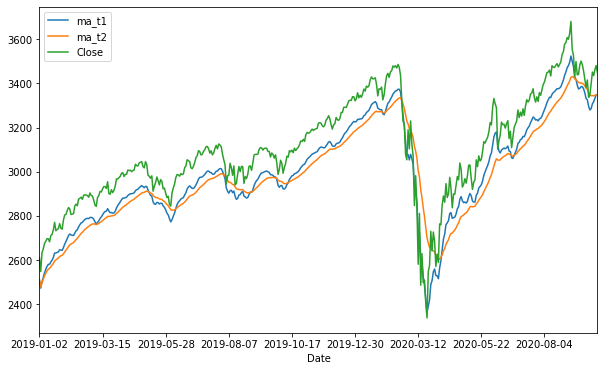

In [266]:
for money_train, t1, t2 in sorted(results_test, reverse=True)[:1]:
    if t2 <= t1:
        continue
    print(t1, t2)
    # df['ma_t1'] = df.Close.rolling(t1).mean()
    # df['ma_t2'] = df.Close.rolling(t2).mean()
    df['ma_t1'] = df.Close.ewm(span=t1).mean()
    df['ma_t2'] = df.Close.ewm(span=t2).mean()

    df['d_t1_t2'] = df['ma_t1'] - df['ma_t2']
    df['d_t1_t2_sign'] = df['d_t1_t2'] > 0
    df['sign_change'] = (df['d_t1_t2_sign'] - df['d_t1_t2_sign'].shift())

    dfp = df.copy().reset_index(drop=True)
    print((get_invest(dfp, is_verbal=True), t1, t2))
        
f, a = plt.subplots(figsize=(10, 6))
dfp.Close = dfp.Close + 100
dfp = dfp.set_index('Date')
dfp[['ma_t1', 'ma_t2', 'Close']].plot(ax=a                        )

In [267]:
(dfp.Close.tail(1).values / dfp.Close.head(1).values * 100)[0]

132.12261928023815

## SP500 index: Auto-correlation of SP500

In [52]:
stock_us_daily_df = ak.stock_us_daily(symbol="SPY", adjust="")
print(stock_us_daily_df)

              open     high     low   close      volume        amount
date                                                                 
1993-01-29   43.97   43.970   43.75   43.94   1003200.0  0.000000e+00
1993-02-01   43.97   44.250   43.97   44.25    480500.0  0.000000e+00
1993-02-02   44.22   44.380   44.13   44.34    201300.0  0.000000e+00
1993-02-03   44.41   44.840   44.38   44.81    529400.0  0.000000e+00
1993-02-04   44.97   45.090   44.88   45.00    531500.0  0.000000e+00
...            ...      ...     ...     ...         ...           ...
2021-04-12  410.85  411.930  410.20  411.64  56704879.0  6.975780e+10
2021-04-13  411.53  413.529  411.12  412.86  56550759.0  6.975780e+10
2021-04-14  412.83  413.960  410.87  411.45  61659731.0  6.975780e+10
2021-04-15  413.74  416.160  413.69  415.87  60229829.0  6.975780e+10
2021-04-16  417.25  417.910  415.73  417.26  82037278.0  6.975780e+10

[7099 rows x 6 columns]


In [6]:
df = stock_us_daily_df

price_type = 'close'
price_2020 = df.loc[(stock_us_daily_df.index.year == 2020) & (stock_us_daily_df.index.dayofyear <= 182), price_type]

In [143]:
w_len = len(price_2020)
corr = []
ds = []
ind = []
for i in range(0, len(df), 5):
    if i + w_len - 1 > len(df):
        break
    open_window = df.iloc[i:i+w_len, :][price_type]
    corr_v = np.corrcoef(price_2020, open_window)[0, 1]
    if corr_v > 0.7:
        ind.append(i)
        corr.append(corr_v)
        ds.append(open_window.index.values[0])

In [144]:
df_corr = pd.DataFrame([ind, ds, corr], index=['ind', 'date', 'corr']).T
n_days = 410

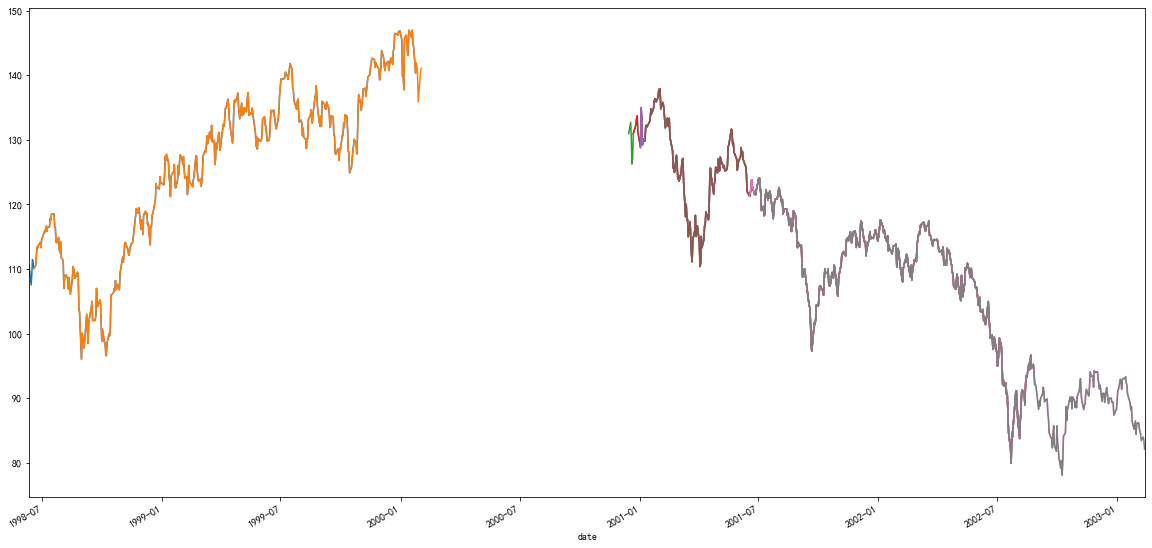

In [76]:
f, a = plt.subplots(figsize=(20, 10))
len_c = len(df_corr)
for i in df_corr.ind.values[:len_c // 4]:
    df.iloc[i:i+n_days, :][price_type].plot(ax=a)

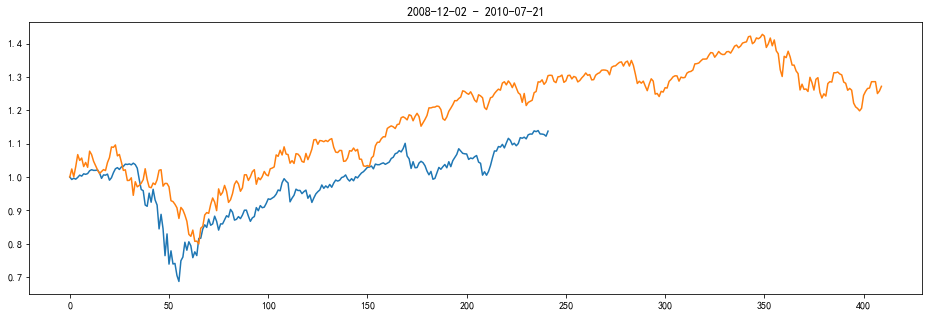

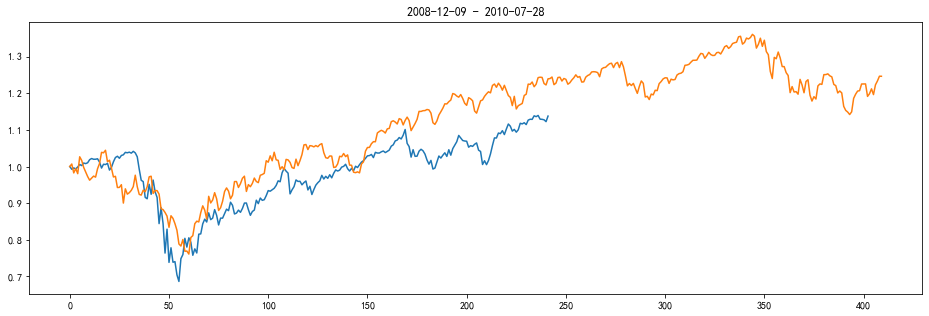

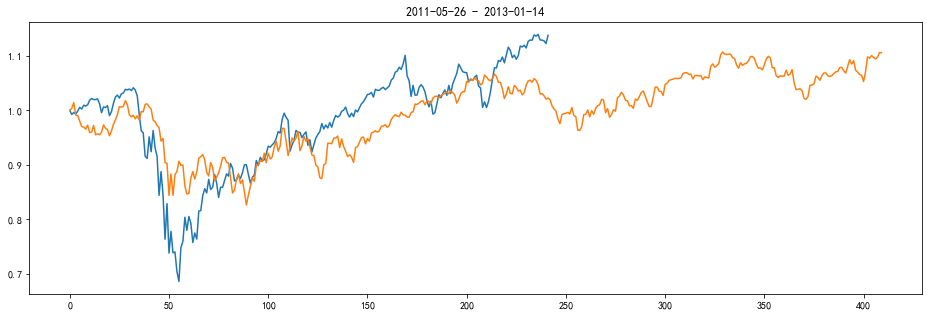

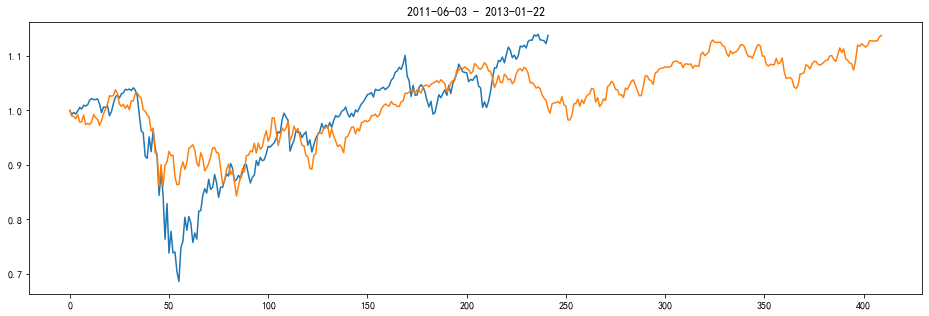

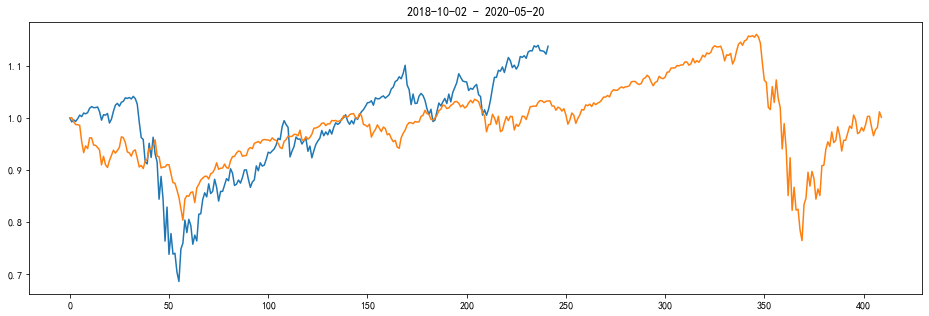

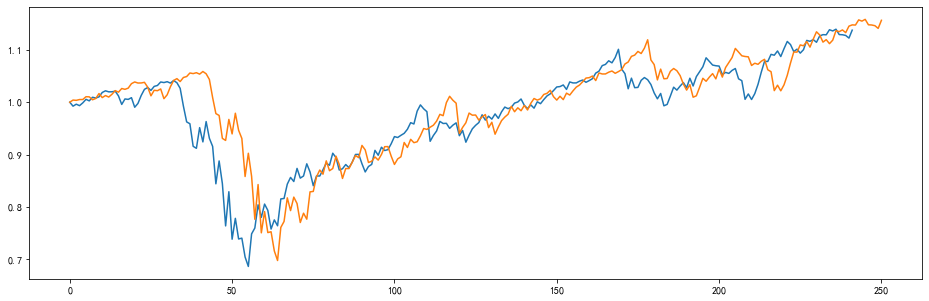

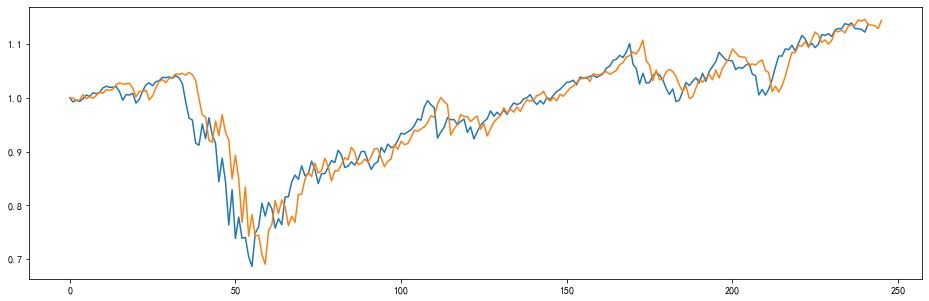

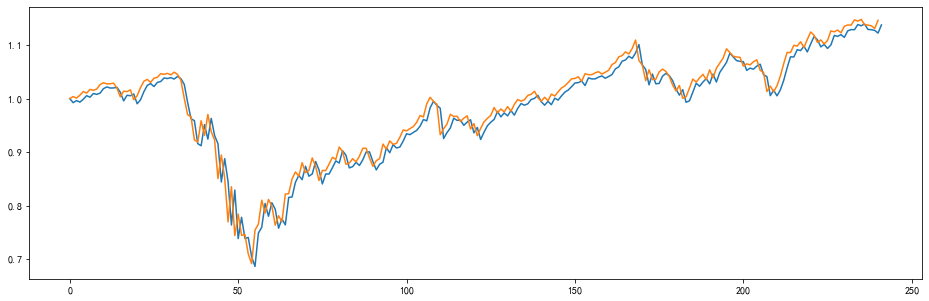

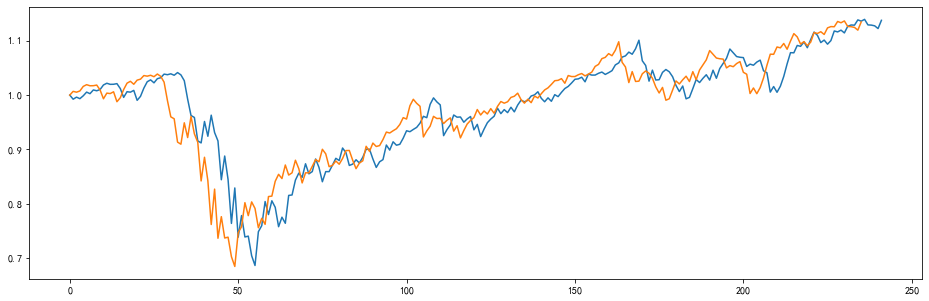

In [153]:
len_c = len(df_corr)
v0 = df.loc[(stock_us_daily_df.index.year == 2020), price_type].values.copy()
v0 = v0 / v0[0]
def plot_series(s, e):
    for i in df_corr.ind.values[s:e] :
        v1 = df.iloc[i:i+n_days, :][price_type].values.copy()
        v1 = v1 / v1[0]
        if v1[0] > v1[-1] or v1.min() > 0.85:
            continue
        f, a = plt.subplots(figsize=(16, 5))
        a.plot(v0)
        a.plot(v1)
        if i+n_days < len(df):
            a.set_title(f'{str(df.index[i].date())} - {str(df.index[i+n_days].date())}')
    
plot_series(s=0, e=len_c)

In [7]:
v0 = df.loc[df.index > pd.Timestamp('2020-01-01 00:00:00'), price_type]
v0 = v0 / v0.iloc[0]

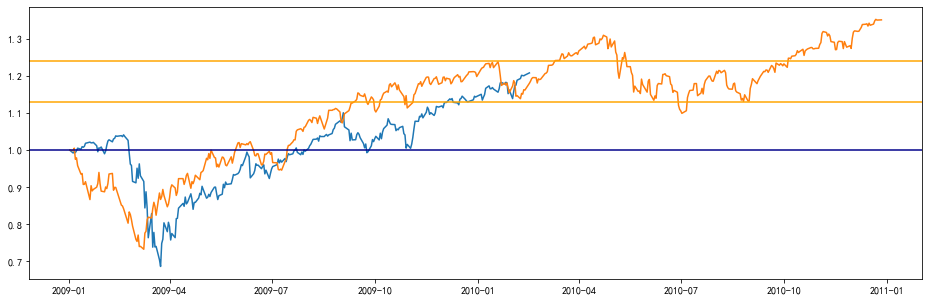

In [8]:
df_v1 = df.loc[(stock_us_daily_df.index.year.isin([2009, 2010])), price_type].iloc[:500].copy()
v1 = df_v1.values
v1 = v1 / v1[0]
f, a = plt.subplots(figsize=(16, 5))
a.plot(df_v1.index[:len(v0)], v0)
a.plot(df_v1.index, v1)
a.axhline(1.13, c='orange')
a.axhline(1.24, c='orange')
a.axhline(1.0, c='darkblue')


## Stock vs M2

In [ ]:
symbol = "SPY"
stock_us_daily_df = ak.stock_us_daily(symbol=symbol, adjust="")
m2_weekly = pd.read_csv('WM2NS.csv')
m2_weekly['DATE'] = pd.to_datetime(m2_weekly['DATE'])

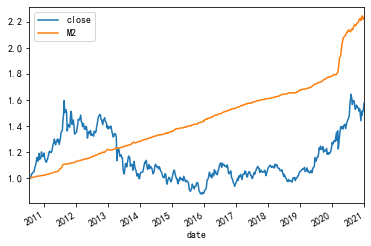

In [19]:
joined = stock_us_daily_df.join(m2_weekly.set_index('DATE')).dropna()
joined['close'] = joined['close'] / joined['close'].values[0]
joined['M2'] = joined['M2'] / joined['M2'].values[0]
joined[['close', 'M2']].plot()

# Regression to check if the price is too far away from M2 and Earning

Ideas from https://seekingalpha.com/article/4396638-visa-fair-price-and-upside-potential

## Functions and data

In [3]:
def note_by_dev_strict(x):
    if x >= 0:
        return 'undervalued'
    else:
        return 'overvalued'

def note_by_dev(x):
    if x > 10:
        return 'undervalued'
    elif x < -10:
        return 'overvalued'
    else:
        return 'edge'

In [4]:
# old M2 From https://fred.stlouisfed.org/series/M2
# new M2, weekly non season-adjusted - https://fred.stlouisfed.org/series/WM2NS
m2_monthly = pd.read_csv('WM2NS.csv')
m2_monthly.columns = ['date', 'm2']

m2_monthly = get_quarter(m2_monthly)
m2_quarterly = m2_monthly.groupby(level=0)['m2'].mean()
# m2_quarterly = m2_quarterly[m2_quarterly.year >= 1981]

In [5]:
def get_stock_price(stock_symbol):
    
    # Get data and format date
    # Data from https://www.macrotrends.net/stocks/research
    stock_us_fundamental_df = ak.stock_us_fundamental(stock=stock_symbol, symbol="PE")
    stock_us_fundamental_df = get_quarter(stock_us_fundamental_df)
    stock_us_fundamental_df['stock'] = stock_symbol
    print(f"\n{stock_symbol}. Last quarter:\n{stock_us_fundamental_df.iloc[-2, :][['stock_price', 'ttm_net_eps']]}")
    
    # Cut the beginning to get full year
    if not stock_us_fundamental_df.index[0].endswith('Q1'):
        stock_us_fundamental_df = stock_us_fundamental_df[stock_us_fundamental_df.year > stock_us_fundamental_df.year.iloc[0]]

    # Get features
    stock_us_fundamental_df = stock_us_fundamental_df.join(m2_quarterly)
    stock_us_fundamental_df['ttm_net_eps'] = stock_us_fundamental_df['ttm_net_eps'].str[1:]
    stock_us_fundamental_df['ttm_net_eps'][stock_us_fundamental_df['ttm_net_eps'] == ''] = '0'
    stock_us_fundamental_df['ttm_net_eps'] = stock_us_fundamental_df['ttm_net_eps'].astype(float)
    
    stock_us_fundamental_df['ttm_net_eps_prev_q'] = stock_us_fundamental_df['ttm_net_eps'].shift(1)
    stock_us_fundamental_df['ttm_net_eps_delta'] = \
        stock_us_fundamental_df['ttm_net_eps'] - stock_us_fundamental_df['ttm_net_eps_prev_q']
    stock_us_fundamental_df['ttm_net_eps_delta_frac'] = \
        stock_us_fundamental_df['ttm_net_eps_delta'] / stock_us_fundamental_df['ttm_net_eps_prev_q']
    
    stock_us_fundamental_df['ttm_net_eps_norm'] = \
        stock_us_fundamental_df['ttm_net_eps'] / stock_us_fundamental_df['m2']

    # Get dep var
    stock_us_fundamental_df['price_next_q'] = stock_us_fundamental_df['stock_price'].shift(-1)
    stock_us_fundamental_df['price_next_q_log'] = stock_us_fundamental_df['price_next_q'].apply(np.log10)
    stock_us_fundamental_df['stock_price_log'] = stock_us_fundamental_df['stock_price'].apply(np.log10)

    return stock_us_fundamental_df

def plot_predictions(stock_us_fundamental_df, y_name, stock_name=''):
    f, a = plt.subplots(figsize=(20, 6))
#     stock_us_fundamental_df['m2_normalized'] = stock_us_fundamental_df['m2'] /\
#         stock_us_fundamental_df['m2'].mean() * stock_us_fundamental_df[y_name].mean()
#     stock_us_fundamental_df['ttm_net_eps_normalized'] = stock_us_fundamental_df['ttm_net_eps'] /\
#         stock_us_fundamental_df['ttm_net_eps'].mean() * stock_us_fundamental_df[y_name].mean()
    stock_us_fundamental_df[[y_name, 'predictions', 
    #                          'm2_normalized', 'ttm_net_eps_normalized'
                            ]].plot(ax=a)
    dates = stock_us_fundamental_df.index.values
    a.set_xticks(range(len(dates)))
    a.set_xticklabels(dates, rotation=40, ha='right')
    a.grid(which='major', alpha=0.5)
    a.set_title(stock_name)

## Modeling

In [6]:
eps_ttm_last = None #0.23 # ROST # AEP # 16 # TMO # 2.5 # ABT  #6.30  # MCD # 41 # AMZN
all_stocks = [
    'AEP', 'AMZN', 'BABA','CMCSA','FB', 'KO','NFLX','OHI', 'TMO',
    'GOOGL', 'COST', 'WMT',  'MCD', 'SBUX', 'BRK.B',
#     'EA', 'HPQ','LUV', 'EXPE', 
    'PG','AAPL','DIS', 'MSFT', 
    'EDU', 'ROST','TSLA', 
#     'TCEHY',
]
tgt_p = []
dfs = pd.DataFrame()

# coef_eps_neg = ['CMCSA', 'WMT', 'SBUX', 'PG', 'AAPL', 'EDU']: #


AEP. Last quarter:
stock_price    83.99
ttm_net_eps    $4.60
Name: 2021Q1, dtype: object


,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q3,79.65,81.81,3.87,102.734742,20.58
2020Q4,81.81,83.99,4.44,108.299034,18.43
2021Q1,83.99,82.97,4.60,113.608231,18.26


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     184.1
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           5.61e-26
Time:                        06:53:49   Log-Likelihood:                -160.48
No. Observations:                  51   AIC:                             329.0
Df Residuals:                      47   BIC:                             336.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -48.2386      4.647    -10.380      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q3,3148.73,3256.93,34.15,2950.894116,92.20
2020Q4,3256.93,3094.08,41.77,3358.444807,77.97
2021Q1,3094.08,3264.11,52.55,3909.373692,58.88


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     363.0
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           1.05e-29
Time:                        06:53:51   Log-Likelihood:                -328.10
No. Observations:                  51   AIC:                             662.2
Df Residuals:                      48   BIC:                             668.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1194.0536    123.700     -9.653      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q2,215.70,293.98,9.28,266.433221,23.24
2020Q3,293.98,232.73,6.97,260.127494,42.18
2020Q4,232.73,215.82,8.58,306.378321,27.12


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     8.728
Date:                Wed, 09 Jun 2021   Prob (F-statistic):            0.00301
Time:                        06:53:53   Log-Likelihood:                -65.257
No. Observations:                  15   AIC:                             138.5
Df Residuals:                      11   BIC:                             141.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -224.2546    236.449     -0.948      0.3

c:\users\yuwei\tools\env\penv\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))



CMCSA. Last quarter:
stock_price    53.86
ttm_net_eps    $2.53
Name: 2021Q1, dtype: object

COEF FOR EPS IS NEGATIVE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 



,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q3,45.60,51.92,2.23,60.213319,20.45
2020Q4,51.92,53.86,2.28,63.196925,22.77
2021Q1,53.86,56.43,2.53,66.323396,21.29


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     339.8
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           7.46e-32
Time:                        06:53:55   Log-Likelihood:                -118.55
No. Observations:                  51   AIC:                             245.1
Df Residuals:                      47   BIC:                             252.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -35.3936      2.380    -14.870      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q3,261.90,273.16,8.78,297.295446,29.83
2020Q4,273.16,294.53,10.10,316.814223,27.05
2021Q1,294.53,333.68,11.69,338.906113,25.20


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     65.24
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           2.12e-11
Time:                        06:53:57   Log-Likelihood:                -111.57
No. Observations:                  27   AIC:                             231.1
Df Residuals:                      23   BIC:                             236.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -252.7048     86.888     -2.908      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q3,48.58,54.39,1.92,61.748071,25.30
2020Q4,54.39,52.71,1.79,63.885693,30.38
2021Q1,52.71,55.65,1.67,66.316103,31.56


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     250.2
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           6.85e-29
Time:                        06:54:00   Log-Likelihood:                -116.35
No. Observations:                  51   AIC:                             240.7
Df Residuals:                      47   BIC:                             248.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.5918      2.185     -7.136      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q3,500.03,540.73,6.20,649.441354,80.65
2020Q4,540.73,521.66,6.09,655.818103,88.79
2021Q1,521.66,492.39,8.27,823.133800,63.08


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     127.9
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           1.29e-22
Time:                        06:54:02   Log-Likelihood:                -260.04
No. Observations:                  51   AIC:                             528.1
Df Residuals:                      47   BIC:                             535.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -222.3147     34.219     -6.497      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q3,28.24,35.05,0.69,39.184618,40.93
2020Q4,35.05,36.00,0.69,41.344189,50.80
2021Q1,36.00,36.69,0.99,44.472660,36.36


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     155.9
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           1.99e-24
Time:                        06:54:04   Log-Likelihood:                -121.00
No. Observations:                  51   AIC:                             250.0
Df Residuals:                      47   BIC:                             257.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.6288      1.775    -11.056      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q3,441.06,465.51,12.20,430.579958,36.15
2020Q4,465.51,456.38,15.95,537.491363,29.19
2021Q1,456.38,441.00,19.86,646.582733,22.98


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     200.4
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           8.85e-27
Time:                        06:54:06   Log-Likelihood:                -228.55
No. Observations:                  51   AIC:                             465.1
Df Residuals:                      47   BIC:                             472.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -104.9809     30.118     -3.486      0.0

,stock_price,price_next_q,ttm_net_eps,predictions,pe_ratio
quarter,,,,,
2020Q3,1465.60,1752.64,51.75,1631.403823,28.32
2020Q4,1752.64,2062.52,58.70,1719.031252,29.86
2021Q1,2062.52,2398.44,75.12,1851.049651,27.46


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     196.6
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           1.34e-26
Time:                        06:54:09   Log-Likelihood:                -303.89
No. Observations:                  51   AIC:                             615.8
Df Residuals:                      47   BIC:                             623.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -890.5268    104.834     -8.495      0.0

IndexError: 0

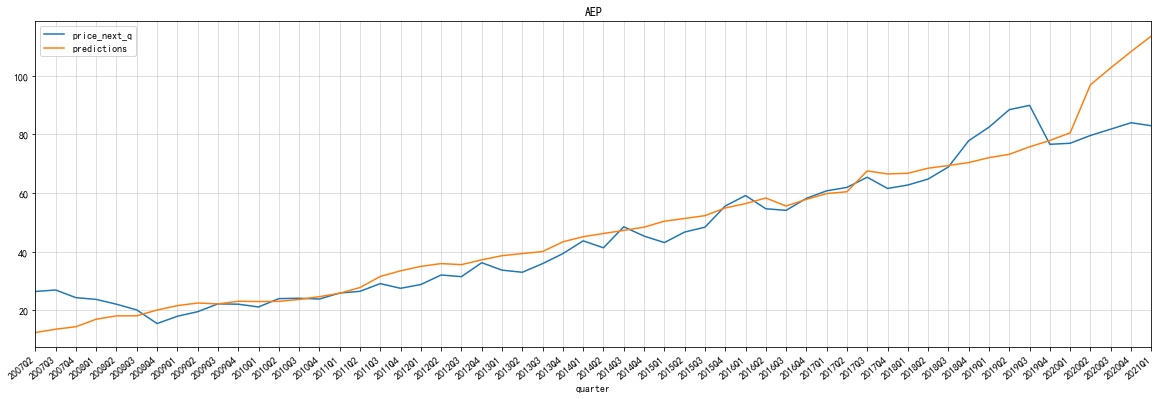

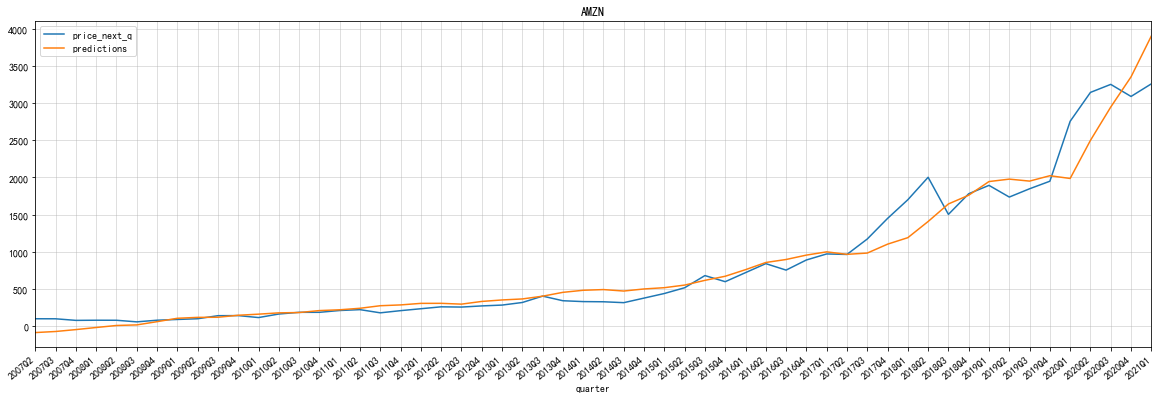

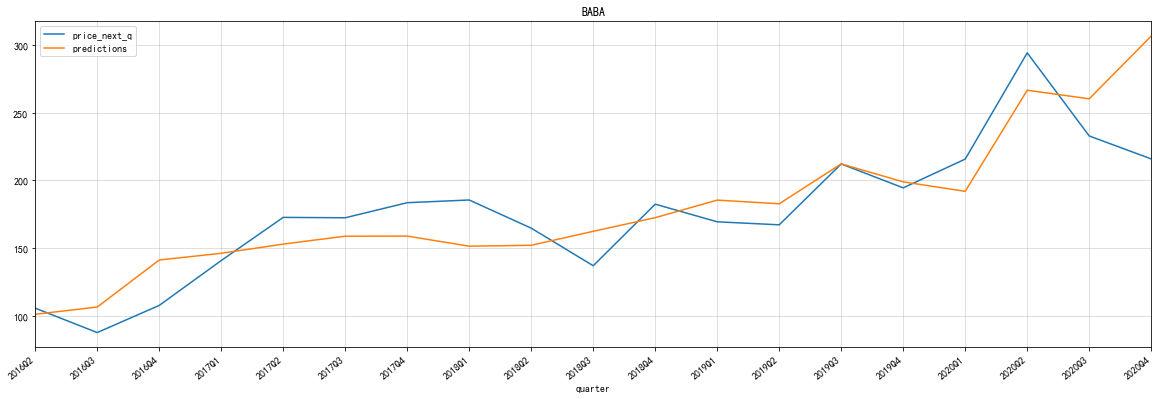

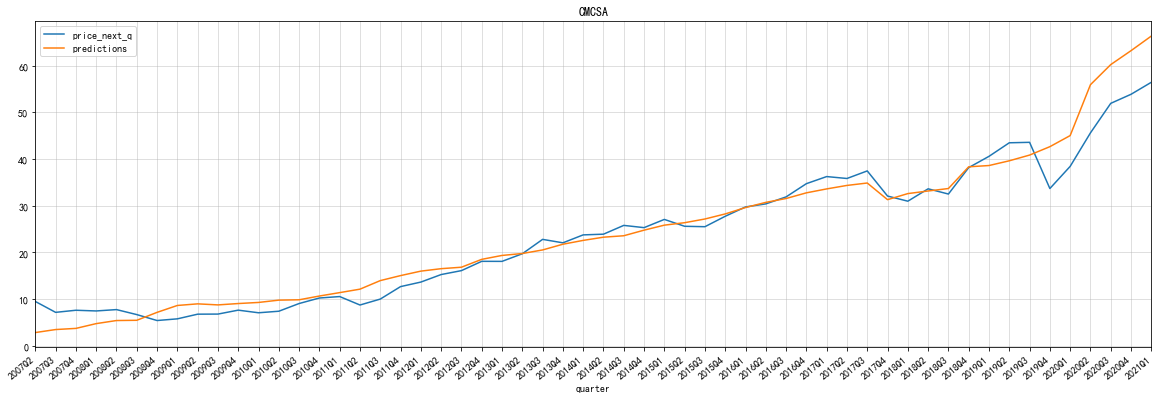

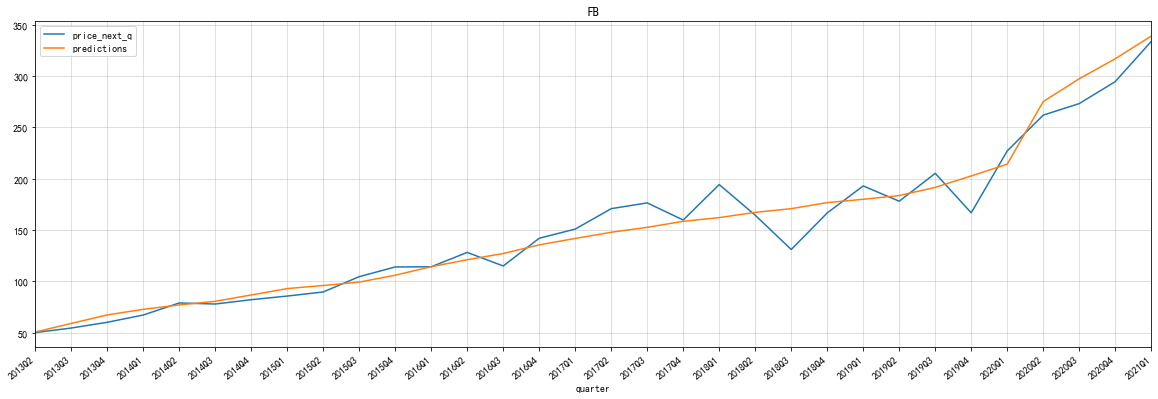

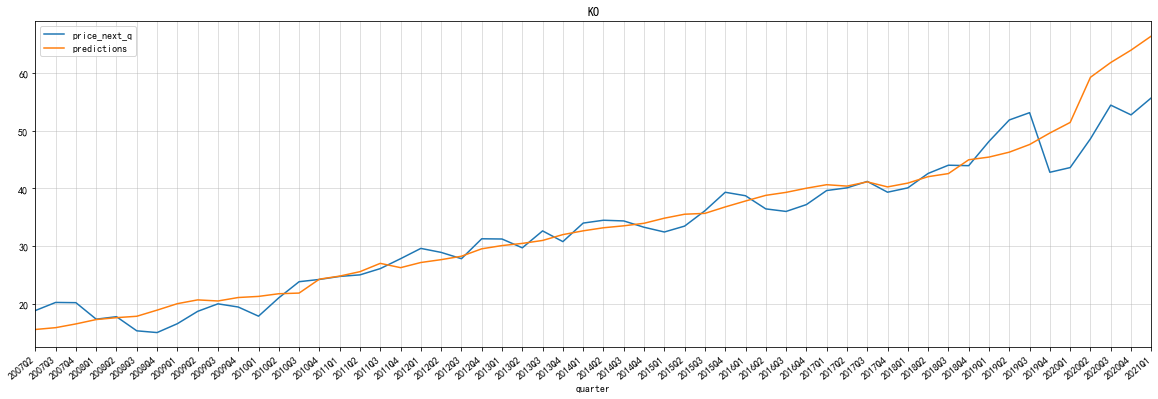

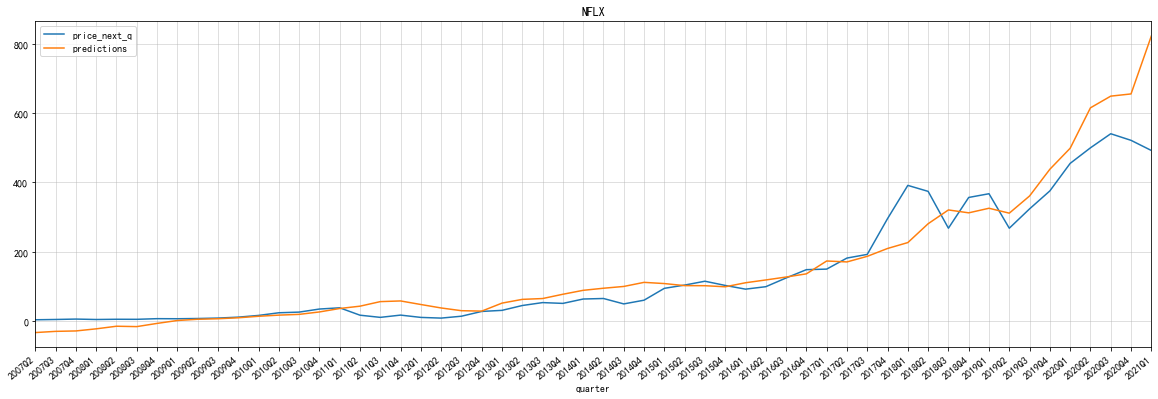

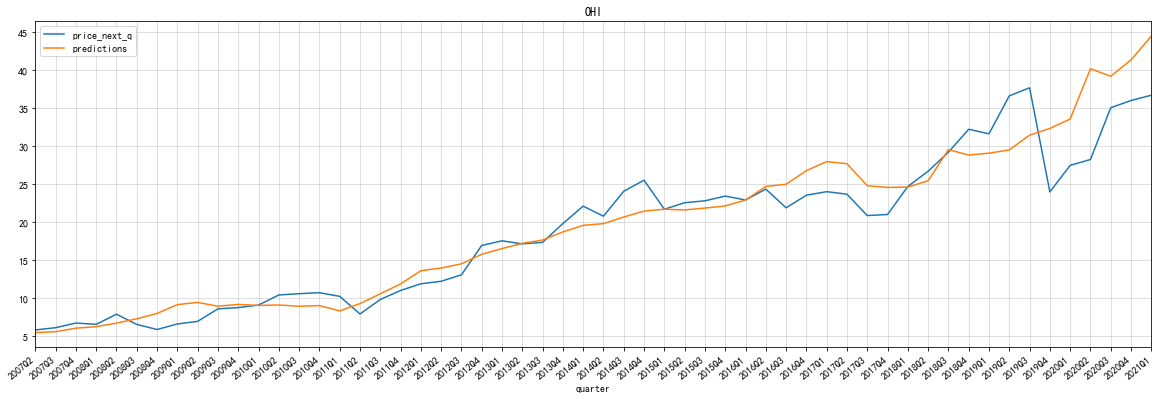

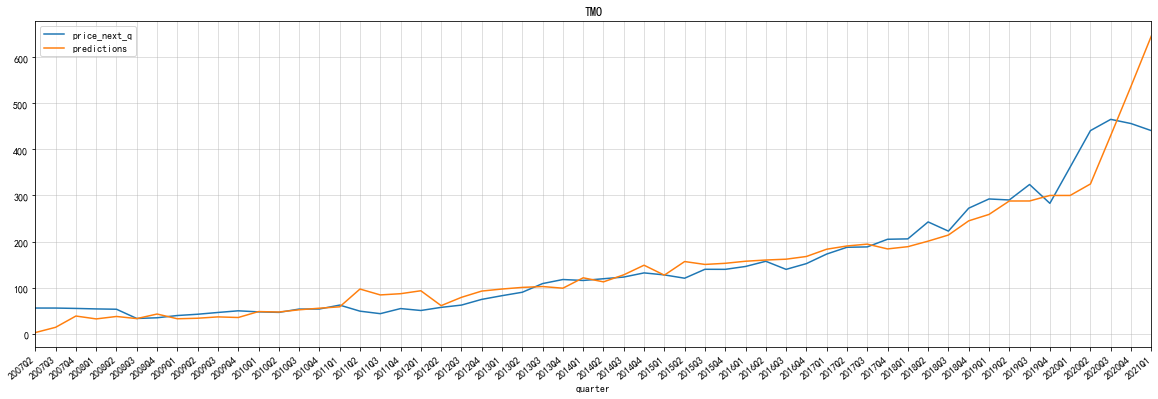

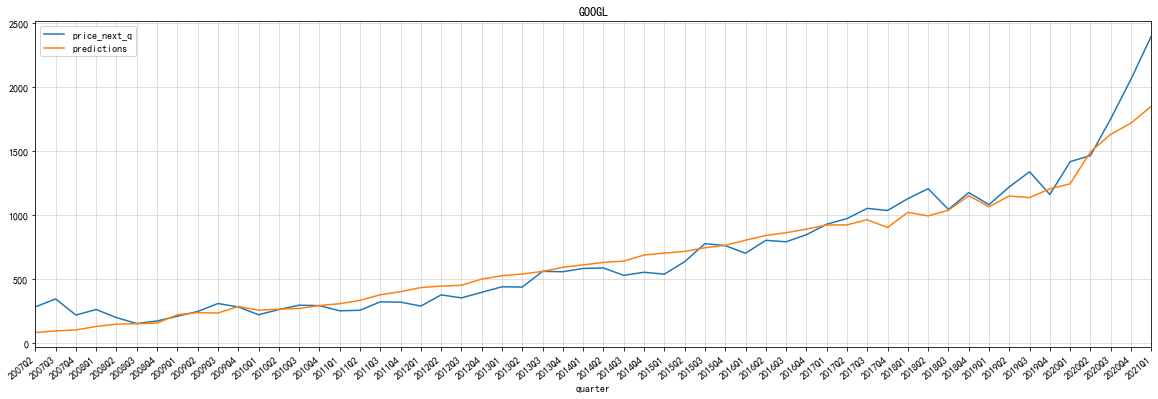

In [7]:
## Some analysis
# df[['ttm_net_eps_delta', 'price_next_q', 'ttm_net_eps', 'pe_ratio']].corr()
# df[['ttm_net_eps_delta', 'pe_ratio']].plot()
# df[['ttm_net_eps_delta', 'price_next_q', 'ttm_net_eps']].hist()

## Modeling
# eps_last_q of some stocks is not accurate
for stock_symbol in all_stocks:
    # Skip already modeled stocks
    if stock_symbol in dfs.stock.unique():
        print(f"Already modeled {stock_symbol}")
        continue
    
    df = get_stock_price(stock_symbol)  
    # Change values manually for corrected ER
    if eps_ttm_last:
        df['ttm_net_eps'].iloc[-1] = eps_ttm_last
        print('OVERWRITE LAST QUARTER TTM_NET_EPS!!!!!!!!!!!!!\n')

    pe_current = df['pe_ratio'].values[-1]
    pe_median = df['pe_ratio'].median()
    pe_current_to_median = pe_current / pe_median 
    # The first row doesn't have prev quarter earning. 
    # The last row is the day when data is pulled
    df = df.iloc[1:-1, :]
    # print(df.tail())

    feature_name = [
        'ttm_net_eps', 
        'm2',
    #     'ttm_net_eps_norm'
    #     'ttm_net_eps_delta',
    #     'pe_ratio',
    ]
    # Use growth rate only if all earnings are positive
    if all(df['ttm_net_eps'] > 0):
        feature_name.append('ttm_net_eps_delta_frac')
        
    y_list = ['price_next_q', 'stock_price']
    y_name = y_list[0]

    # Remove 2020 when training models
    df_train = df[df.year < 2020]

    X = sm.add_constant(df_train[feature_name].values)
    y = df_train[y_name].values
    model = sm.OLS(y, X).fit()

#     mod = sm.ols(formula=f'{y_name} ~ ttm_net_eps + m2', data=df_train)
#     model = mod.fit()
    
    X_pred = sm.add_constant(df[feature_name].values)
    df['predictions'] = model.predict(X_pred)
    if model.params[1] < 0:
        print('\nCOEF FOR EPS IS NEGATIVE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! \n')
    display(df[['stock_price', 'price_next_q', 'ttm_net_eps', 'predictions', 'pe_ratio']].tail(3))
    print(model.summary())
#     print(f"""Adj. R^2: {model.rsquared_adj:.2}  P-values: {[round(i, 3) for i in model.pvalues[1:]]}""")

    tgt_p.append((stock_symbol, 
                  df['price_next_q'].values[-1].round(), 
                  df['predictions'].values[-1].round(),
                  model.rsquared_adj.round(2),
                  pe_current, 
                  pe_current_to_median,
                  int(model.params[1] < 0),
                 ))
    # The last row for price_next_q is the CURRENT PRICE
    plot_predictions(df, y_name, stock_symbol)
    dfs = pd.concat([dfs, df])
    print('____________________________________________________________________________________')

#### Additional data for the stock

In [8]:
# plot_predictions(df.iloc[:-12, :], y_name, stock_symbol)

#### Get note for under/over value

In [9]:
df_p = pd.DataFrame(tgt_p, columns=['stock', 'p_current', 'p_predict', 
                                    'rsquare_adj', 'pe_current', 'pe_current_to_median', 'is_eps_coef_neg'])
df_p['dev%'] = ((df_p['p_predict'] / df_p['p_current'] - 1) * 100).round()

df_p['note'] = df_p['dev%'].apply(note_by_dev)

df_p.to_csv('tgt_price.csv', index=False)

# df_p[df_p.is_eps_coef_neg == 1].stock.values

In [10]:
for k, v in df_p.groupby('note'):
    display(v.sort_values('stock'))

,stock,p_current,p_predict,rsquare_adj,pe_current,pe_current_to_median,is_eps_coef_neg,dev%,note
4,FB,334.0,339.0,0.88,28.54,0.819173,0,1.0,edge


,stock,p_current,p_predict,rsquare_adj,pe_current,pe_current_to_median,is_eps_coef_neg,dev%,note
9,GOOGL,2398.0,1851.0,0.92,31.93,1.134281,0,-23.0,overvalued


,stock,p_current,p_predict,rsquare_adj,pe_current,pe_current_to_median,is_eps_coef_neg,dev%,note
0,AEP,83.0,114.0,0.92,18.04,1.479902,0,37.0,undervalued
1,AMZN,3264.0,3909.0,0.94,62.11,0.761992,0,20.0,undervalued
2,BABA,216.0,306.0,0.62,25.15,0.678263,0,42.0,undervalued
3,CMCSA,56.0,66.0,0.95,22.30,1.425376,1,18.0,undervalued
5,KO,56.0,66.0,0.94,33.32,1.877183,0,18.0,undervalued
6,NFLX,492.0,823.0,0.88,59.54,0.745555,0,67.0,undervalued
7,OHI,37.0,44.0,0.90,37.06,2.568261,0,19.0,undervalued
8,TMO,441.0,647.0,0.92,22.21,0.795487,0,47.0,undervalued


## Experiment invest stratege

In [95]:
# dfs.groupby('stock').year.min()
# remove stocks with short history
dfsa = dfs[~dfs.stock.isin(['BABA', 'FB', 'CMCSA', 'TSLA', # too short
                            'COST', 'WMT', # weird q timing
                            'AAPL', 'SBUX', 'PG',  # eps coef neg
                           ])].copy()


year_cut = 2010
method = note_by_dev  # note_by_dev_strict results are worse
CASH_QUARTERLY = 1000  # cash to invest quarterly, but only for quarters with undervalued stocks

dfsa = dfsa[dfsa.year >= year_cut]
dfsa['dev%'] = ((dfsa['predictions'] / dfsa['price_next_q'] - 1) * 100).round()
dfsa['note'] = dfsa['dev%'].apply(method)

rsl = pd.DataFrame()

#### Method 1 - invest on undervalued. don't sell

In [96]:
# Compute total shares bought
dfsa_under = dfsa[dfsa.note == 'undervalued'].copy()
dfsa_under = dfsa_under.join(dfsa_under.groupby(level=0).size().rename('split'))
dfsa_under['dollars_bought'] = CASH_QUARTERLY / dfsa_under['split']
dfsa_under['shares_bought'] = dfsa_under['dollars_bought'] / dfsa_under['stock_price']

def get_values(df):
    df_shares_total = df.groupby('stock', as_index=False).shares_bought.sum()
    df_shares_total = pd.merge(df_shares_total, dfsa[dfsa.index == df.index.max()][['stock', 'stock_price']], on='stock')
    df_shares_total['value'] = df_shares_total['stock_price'] * df_shares_total['shares_bought']
    return df_shares_total

for q in dfsa_under.index.unique().values:
    if q.endswith('Q4'):
        g = dfsa_under[dfsa_under.index <= q]
        df_shares_total = get_values(g)
        rsl = rsl.append(pd.DataFrame([q, g.index.nunique() * CASH_QUARTERLY, df_shares_total['value'].sum(), '1'],
                                      index=['year', 'cost', 'value', 'method']).T)
#         print(f"On {q} - cost: {g.index.nunique() * CASH_QUARTERLY}; value: {df_shares_total['value'].sum():.0f}")

#### Method 1.1 - invest all money at the beginning and hold

In [97]:
CASH_IF_INVEST_ALL = CASH_QUARTERLY * dfsa_under.index.nunique()

In [98]:
stock_shares = {}
cash_residual = CASH_IF_INVEST_ALL
cost = CASH_IF_INVEST_ALL

dfsa_t0 = dfsa[dfsa.index == dfsa.index.min()]
dollars_bought = cash_residual / len(dfsa_t0)

for _, row in dfsa_t0.iterrows():
    stock_shares[row['stock']] = stock_shares.get(row['stock'], 0) + dollars_bought / row['stock_price']

for k, g in dfsa.groupby(level=0):
    if k.endswith('Q4'):
        rsl = rsl.append(pd.DataFrame([k, cost, cash_residual + sum([g[g.stock == k]['stock_price'].values * v for k, v in stock_shares.items()])[0], '1.1'],
                              index=['year', 'cost', 'value', 'method']).T)

#### Method 1.2 - invest all money at the beginning, rebalance by selling overvalued and buying undervalued each quarter

In [99]:
stock_shares = {}
cash_residual = CASH_IF_INVEST_ALL
cost = CASH_IF_INVEST_ALL
for k, g in dfsa.groupby(level=0):
    overvalued = g[g.note == 'overvalued']
    undervalued = g[g.note == 'undervalued']
        
    # Buy undervalued if any; Sell overvalued only if there are something to buy
    if len(undervalued) > 0:
        # Sell overvalued
        for _, row in overvalued.iterrows():
            cash_residual += stock_shares.pop(row['stock'], 0) * row['stock_price']
        # Buy undervalued
        dollars_bought = cash_residual / len(undervalued)
        for _, row in undervalued.iterrows():
            stock_shares[row['stock']] = stock_shares.get(row['stock'], 0) + dollars_bought / row['stock_price']
        cash_residual = 0
        
    if k.endswith('Q4'):
        rsl = rsl.append(pd.DataFrame([k, cost, cash_residual + sum([g[g.stock == k]['stock_price'].values * v for k, v in stock_shares.items()])[0], '1.2'],
                              index=['year', 'cost', 'value', 'method']).T)

#### Method 1.5 - invest on undervalued, sell overvalued

In [100]:
CASH_QUARTERLY_IF_INVEST_ALL = CASH_QUARTERLY * dfsa_under.index.nunique() / dfsa.index.nunique()

In [101]:
stock_shares = {}
cash_residual = 0
cost = 0
for k, g in dfsa.groupby(level=0):
    overvalued = g[g.note == 'overvalued']
    undervalued = g[g.note == 'undervalued']

    # Get initial cash for this quarter = new money + residual from last time
    cash_residual += CASH_QUARTERLY_IF_INVEST_ALL

#     print(k)
#     if not overvalued.empty:
#         print(f'Sell {overvalued.stock.values} if any')
#     print(f'cash_residual: {cash_residual}')
#     if not undervalued.empty:
#         print(f'Buy {undervalued.stock.values}')
        
    # Buy undervalued if any; Sell overvalued only if there are something to buy
    if len(undervalued) > 0:
        # Sell overvalued
        for _, row in overvalued.iterrows():
            cash_residual += stock_shares.pop(row['stock'], 0) * row['stock_price']
        # Buy undervalued
        dollars_bought = cash_residual / len(undervalued)
        for _, row in undervalued.iterrows():
            stock_shares[row['stock']] = stock_shares.get(row['stock'], 0) + dollars_bought / row['stock_price']
        cash_residual = 0
        
    if k.endswith('Q4'):
        cost += CASH_QUARTERLY_IF_INVEST_ALL * 4 
        rsl = rsl.append(pd.DataFrame([k, cost, 
                                       cash_residual + sum([g[g.stock == k]['stock_price'].values * v for k, v in stock_shares.items()])[0], '1.5'],
                              index=['year', 'cost', 'value', 'method']).T)
#         print(f"On {k} - cost: {cost:.0f}; stock value: {sum([g[g.stock == k]['stock_price'].values * v for k, v in stock_shares.items()])[0]:.0f}",
#              f"cash: {cash_residual}")

#### Method 1.8 - invest on undervalued, sell if 10% lower than previous quarter - very bad, ignore

In [102]:
stock_shares = {}
prev = None
cash_residual = 0
cost = 0
for k, g in dfsa.groupby(level=0):
    
    break
    
    
    
    
    undervalued = g[g.note == 'undervalued']

    # Get initial cash for this quarter = new money + residual from last time
    cash_residual += CASH_QUARTERLY_IF_INVEST_ALL

#     print(k)
#     if not overvalued.empty:
#         print(f'Sell {overvalued.stock.values} if any')
#     print(f'cash_residual: {cash_residual}')
#     if not undervalued.empty:
#         print(f'Buy {undervalued.stock.values}')
        
    # Sell if 10% off then previous
    if k > dfsa.index.min():
        merged = pd.merge(prev[['stock', 'stock_price']], g[['stock', 'stock_price']], on='stock', suffixes=('_prev', ''))
        merged['frac_change'] = merged['stock_price'] / merged['stock_price_prev'] - 1
        stocks_to_buy = merged[merged['frac_change'] < -0.1][['stock', 'stock_price']]
        if not stocks_to_buy.empty:
            for s, p in stocks_to_buy.values:
                cash_residual += stock_shares.pop(s, 0) * p
            print(f'On {k}, sell {stocks_to_buy.stock.values}. Cash: {cash_residual}')

    # Buy undervalued if any
    if len(undervalued) > 0:
        # Buy undervalued
        dollars_bought = cash_residual / len(undervalued)
        for _, row in undervalued.iterrows():
            stock_shares[row['stock']] = stock_shares.get(row['stock'], 0) + dollars_bought / row['stock_price']
        cash_residual = 0
    
    prev = g
    
    if k.endswith('Q4'):
        cost += CASH_QUARTERLY_IF_INVEST_ALL * 4 
        rsl = rsl.append(pd.DataFrame([k, cost, 
                                       cash_residual + sum([g[g.stock == k]['stock_price'].values * v for k, v in stock_shares.items()])[0], '1.8'],
                              index=['year', 'cost', 'value', 'method']).T)
#         print(f"On {k} - cost: {cost:.0f}; stock value: {sum([g[g.stock == k]['stock_price'].values * v for k, v in stock_shares.items()])[0]:.0f}",
#              f"cash: {cash_residual}")

#### Method 2 - invest on all but only at times when some stocks are under

In [103]:
dfsa_same_time = dfsa[dfsa.index.isin(dfsa_under.index.unique().values)].copy()
dfsa_same_time['dollars_bought'] = CASH_QUARTERLY / dfsa_same_time.stock.nunique()
dfsa_same_time['shares_bought'] = dfsa_same_time['dollars_bought'] / dfsa_same_time['stock_price']

for q in dfsa_same_time.index.unique().values:
    if q.endswith('Q4'):
        g = dfsa_same_time[dfsa_same_time.index <= q]
        df_shares_total = get_values(g)
        rsl = rsl.append(pd.DataFrame([q, g.index.nunique() * CASH_QUARTERLY, df_shares_total['value'].sum(), '2'],
                                      index=['year', 'cost', 'value', 'method']).T)
#         print(f"On {q} - cost: {g.index.nunique() * CASH_QUARTERLY}; value: {df_shares_total['value'].sum():.0f}")

#### method 3 - invest on all over all itime

In [104]:
dfsa['dollars_bought'] = CASH_QUARTERLY_IF_INVEST_ALL / dfsa.stock.nunique()
dfsa['shares_bought'] = dfsa['dollars_bought'] / dfsa['stock_price']

for q in dfsa.index.unique().values:
    if q.endswith('Q4'):
        g = dfsa[dfsa.index <= q]
        df_shares_total = get_values(g)
        rsl = rsl.append(pd.DataFrame([q, g.index.nunique() * CASH_QUARTERLY_IF_INVEST_ALL, df_shares_total['value'].sum(), '3'],
                                      index=['year', 'cost', 'value', 'method']).T)
#         print(f"On {q} - cost: {g.index.nunique() *  CASH_QUARTERLY_IF_INVEST_ALL:.0f}; value: {df_shares_total['value'].sum():.0f}")

### summary

In [105]:
rslp = rsl.pivot(index='year', columns='method', values=['cost', 'value'])

tmp = rslp['value'] / rslp['cost']
tmp.columns = pd.MultiIndex.from_product([["frac_gain"], tmp.columns])
rslp = pd.concat([rslp, tmp], axis=1)

tmp = pd.DataFrame()
for i in rslp['value']:
    tmp = pd.concat([tmp, rslp['frac_gain'][i] / rslp['frac_gain']['1'].rename(i)], axis=1, sort=False)
tmp.columns = pd.MultiIndex.from_product([["frac_to_method_1"], tmp.columns])
rslp = pd.concat([rslp, tmp], axis=1)

rslp.T

year                      2010Q4    2011Q4    2012Q4    2013Q4    2014Q4  \
                 method                                                    
cost             1          4000      8000     12000     16000     20000   
                 1.1       42000     42000     42000     42000     42000   
                 1.2       42000     42000     42000     42000     42000   
                 1.5     3733.33   7466.67     11200   14933.3   18666.7   
                 2          4000      8000     12000     16000     20000   
                 3       3733.33   7466.67     11200   14933.3   18666.7   
value            1       4426.81   9555.67   16656.2   30386.3   35924.1   
                 1.1       94425   93070.4    102577    136664    142246   
                 1.2     49170.4   51006.2   63114.3   92846.1   86759.3   
                 1.5     4131.69   8918.63   15545.8     28288   32407.9   
                 2        4583.7   8574.76   14324.8   26953.1   32997.8   
                 3       4278.12   8003.11   13369.8   25156.2   30797.9   
frac_gain        1        1.1067   1.19446   1.38802   1.89914    1.7962   
                 1.1     2.24821   2.21596   2.44231    3.2539    3.3868   
                 1.2     1.17072   1.21443   1.50272   2.21062    2.0657   
                 1.5      1.1067   1.19446   1.38802   1.89429   1.73614   
                 2       1.14593   1.07185   1.19373   1.68457   1.64989   
                 3       1.14593   1.07185   1.19373   1.68457   1.64989   
frac_to_method_1 1             1         1         1         1         1   
                 1.1     2.03145    1.8552   1.75957   1.71335   1.88553   
                 1.2     1.05785   1.01672   1.08264   1.16401   1.15003   
                 1.5           1         1         1  0.997443  0.966559   
                 2       1.03544  0.897348  0.860028  0.887015  0.918542   
                 3       1.03544  0.897348  0.860028  0.887015  0.918542   

year                       2015Q4    2016Q4    2017Q4   2018Q4    2019Q4  \
                 method                                                    
cost             1          24000     28000     32000      NaN     37000   
                 1.1        42000     42000     42000    42000     42000   
                 1.2        42000     42000     42000    42000     42000   
                 1.5        22400   26133.3   29866.7    33600   37333.3   
                 2          24000     28000     32000      NaN     37000   
                 3          22400   26133.3   29866.7    33600   37333.3   
value            1        55960.7   68995.5   97749.7      NaN    160527   
                 1.1       182652    198201    252595   299820    371989   
                 1.2       136273    154846    192456   242991    263011   
                 1.5        54165   73352.4   96780.3   125036    144929   
                 2        49207.8   59088.8   83898.4      NaN    134992   
                 3        45927.3   55149.6   78305.2    95735    129569   
frac_gain        1         2.3317   2.46412   3.05468      NaN   4.33856   
                 1.1      4.34885   4.71908   6.01416  7.13857   8.85689   
                 1.2       3.2446    3.6868   4.58228  5.78549   6.26216   
                 1.5      2.41808   2.80685   3.24041  3.72132   3.88202   
                 2        2.05033   2.11032   2.62183      NaN   3.64843   
                 3        2.05033   2.11032   2.62183  2.84925   3.47059   
frac_to_method_1 1              1         1         1      NaN         1   
                 1.1       1.8651   1.91512   1.96884      NaN   2.04143   
                 1.2      1.39152   1.49619   1.50009      NaN   1.44337   
                 1.5      1.03705   1.13909    1.0608      NaN  0.894771   
                 2       0.879327  0.856417  0.858299      NaN   0.84093   
                 3       0.879327  0.856417  0.858299      NaN   0.79994   

year                       2020Q4  
          

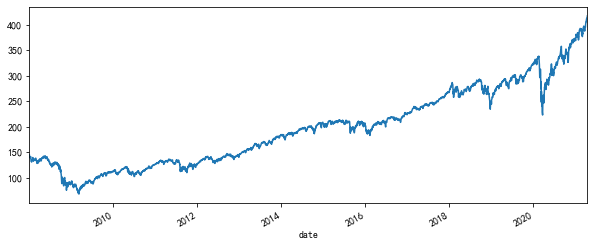

In [63]:
# Check the timing against sp500
sp500 = ak.stock_us_daily(symbol='SPY', adjust="")
f, a = plt.subplots(figsize=(10, 4))
sp500[sp500.index.year > 2007]['close'].plot(ax=a)

# PE PB (04/16/2021)

In [130]:
df_pepb = pd.read_csv('sp500_1_300_history_filterd.csv', index_col=0)
df_pepb['pepb'] = df_pepb['pe_ratio'] * df_pepb['price_to_book_ratio']

## get pepb quantiles and pepb last year

In [131]:
def q05(x):
    return x.quantile(0.05)
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)
def q95(x):
    return x.quantile(0.95)
f = {'pepb': [q05, q25, 'median', q75, q95]}
df_pepb_g = df_pepb[df_pepb.index != '2021Q2'].groupby('stock').agg(f)

df_pepb_g.columns = [f'pepb_{i}' for i in df_pepb_g.columns.get_level_values(1).values]

In [132]:
df_pepb_last_year = df_pepb[df_pepb.year == 2020].groupby('stock')['pepb'].mean()
df_pepb_last_year.name = 'pepb_last_year'

## Check current pepb level

In [160]:
df_pepb_stats = pd.merge(df_pepb[df_pepb.index == '2021Q2'], df_pepb_g, on='stock')
df_pepb_stats = pd.merge(df_pepb_stats, df_pepb_last_year, on='stock')

In [161]:
def get_pepb_note(x):
    note = None
    if x['pepb'] == 0:
        note = 'negtive pepb'
    elif x['pepb'] >= x['pepb_q95']:
        note = 'over q95'
    elif x['pepb'] < x['pepb_q75']:
        note = 'under q75'
    else:
        note = 'over q75, under q95'
    sub = '; over last year' if x['pepb'] > x['pepb_last_year'] else '; under last year'
    return note + sub
df_pepb_stats['pepb_note'] = df_pepb_stats.apply(get_pepb_note, axis=1)

In [162]:
df_pepb_stats_core = (df_pepb_stats[df_pepb_stats.stock.isin(all_stocks)].sort_values('pepb_note')
                      .drop(['date', 'ttm_net_eps', 'book_value_per_share', 'year'], axis=1)
                     )

df_pepb_stats_core[df_pepb_stats_core.pepb_note.str.contains('q75')]

,stock_price,pe_ratio,price_to_book_ratio,stock,pepb,pepb_q05,pepb_q25,pepb_median,pepb_q75,pepb_q95,pepb_last_year,pepb_note
159,53.68,29.99,11.35,KO,340.3865,32.85520,51.966225,71.08835,173.093075,599.00565,210.541900,"over q75, under q95; over last year"
11,88.55,19.94,2.12,AEP,42.2728,4.83960,7.701000,14.36850,28.528500,61.21880,38.637075,"over q75, under q95; over last year"
130,2282.75,38.89,6.93,GOOGL,269.5077,63.94960,86.742000,120.01200,149.860300,371.16096,131.977500,"over q75, under q95; over last year"
213,137.25,25.95,6.96,PG,180.6120,18.19052,25.748100,39.63040,70.562800,365.85092,216.316325,"over q75, under q95; under last year"
194,546.54,89.74,21.88,NFLX,1963.5112,97.87572,277.038600,1901.12880,3794.277000,6395.85728,1697.114750,under q75; over last year
114,306.18,30.31,6.80,FB,206.1080,121.40615,179.443850,239.77815,536.916775,961.85044,154.773875,under q75; over last year
51,272.11,14.76,0.81,BRK.B,11.9556,0.00000,7.614600,9.30510,12.343200,19.62792,15.514850,under q75; under last year
24,3399.44,81.38,18.31,AMZN,1490.0678,0.00000,700.761800,1388.86650,3884.968800,13237.63834,1626.573200,under q75; under last year


In [148]:
df_pepb_stats[df_pepb_stats.pepb_note == 'under q75; under last year'].sort_values('pepb')

,date,stock_price,ttm_net_eps,pe_ratio,book_value_per_share,price_to_book_ratio,stock,year,pepb,pepb_q05,pepb_q25,pepb_median,pepb_q75,pepb_q95,pepb_last_year,pepb_note
51,2021-04-16,272.11,NaN,14.76,NaN,0.81,BRK.B,2021,11.9556,0.000000,7.614600,9.30510,12.343200,19.627920,15.514850,under q75; under last year
69,2021-04-16,64.96,NaN,21.09,NaN,1.46,CNC,2021,30.7914,0.000000,19.298775,38.18610,55.032775,106.326375,32.453333,under q75; under last year
123,2021-04-16,72.38,NaN,16.53,NaN,2.73,FTV,2021,45.1269,19.807050,36.227750,92.85040,111.668600,121.691580,79.828350,under q75; under last year
162,2021-04-16,262.20,NaN,16.58,NaN,2.73,LH,2021,45.2634,31.065160,48.232800,54.61200,67.020800,99.724040,61.053875,under q75; under last year
32,2021-04-16,175.65,NaN,30.03,NaN,1.79,ARE,2021,53.7537,0.000000,26.551800,38.93540,73.317400,169.800760,75.003650,under q75; under last year
127,2021-04-16,61.30,NaN,14.88,NaN,4.08,GIS,2021,60.7104,22.305140,28.817750,42.39310,70.101550,117.865500,65.231475,under q75; under last year
225,2021-04-16,502.60,NaN,16.39,NaN,4.88,REGN,2021,79.9832,0.000000,0.000000,92.48680,469.924300,1809.060480,120.379925,under q75; under last year
196,2021-04-16,346.43,NaN,18.21,NaN,5.46,NOC,2021,99.4266,0.000000,8.650000,25.15720,103.870000,150.885780,104.044250,under q75; under last year
272,2021-04-16,219.39,NaN,21.30,NaN,6.56,VRTX,2021,139.7280,0.000000,0.000000,0.00000,231.420000,2789.647580,288.793125,under q75; under last year
74,2021-04-16,231.91,NaN,52.83,NaN,5.26,CRM,2021,277.8858,0.000000,0.000000,694.22160,2411.771800,10824.950760,1261.279700,under q75; under last year


In [138]:
# df_pepb[df_pepb.stock == 'BRK.B']

,date,stock_price,ttm_net_eps,pe_ratio,book_value_per_share,price_to_book_ratio,stock,year,pepb
quarter,,,,,,,,,
2006Q4,2006-12-31,73.32,4.68,15.67,NaN,0.00,BRK.B,2006,0.0000
2007Q1,2007-03-31,72.80,4.80,15.17,NaN,0.00,BRK.B,2007,0.0000
2007Q2,2007-06-30,72.10,5.14,14.03,NaN,0.00,BRK.B,2007,0.0000
2007Q3,2007-09-30,79.04,5.98,13.22,NaN,0.00,BRK.B,2007,0.0000
2007Q4,2007-12-31,94.72,5.70,16.62,NaN,0.00,BRK.B,2007,0.0000
2008Q1,2008-03-31,89.46,4.98,17.96,NaN,0.00,BRK.B,2008,0.0000
2008Q2,2008-06-30,80.24,4.87,16.48,NaN,0.00,BRK.B,2008,0.0000
2008Q3,2008-09-30,87.90,3.37,26.08,NaN,0.00,BRK.B,2008,0.0000
2008Q4,2008-12-31,64.28,2.15,29.90,154.41,0.42,BRK.B,2008,12.5580


# Earning backtest

In [1]:
def get_earning(ticker, DAYS_AHEAD=-1900):
    # setting the dates
    start_date = (datetime.now().date() + timedelta(days=DAYS_AHEAD))
    end_date = datetime.now().date()

    # downloading the earnings calendar
    yec = YahooEarningsCalendar()
    earnings_list = yec.get_earnings_of(ticker)
    earnings_df = pd.DataFrame(earnings_list)

    # extracting the date from the string and filtering for the period of interest
    earnings_df['report_date'] = earnings_df['startdatetime'].apply(lambda x: dateutil.parser.isoparse(x).date())
    earnings_df = earnings_df.loc[earnings_df['report_date'].between(start_date, end_date)] \
                             .sort_values('report_date')

    return earnings_df

## Check how days before earning can predict price after

In [26]:
experiment_pe_stocks = ['AAPL', 'DIS', 'GOOGL', 'KO', 'MSFT', 'WMT',]

l_stock_pe = []
for symbol in ['MSFT','ROST','TSLA', 'BABA', 'TCEHY',]:  #experiment_pe_stocks:  # ['KO']:
    er_ds_df = get_earning(symbol)
    # er_ds_dict = {symbol: [pd.Timestamp(i) for i in er_ds_df.report_date.values]}
    er_ds = [pd.Timestamp(i) for i in er_ds_df.report_date.values]
    df_stock_price_for_er = ak.stock_us_daily(symbol=symbol, adjust="")

    day_hold_range = [16] # range(7, 25)
    for day_hold in day_hold_range:
        profit_sum = []
        is_positive = []
        for day_er in er_ds:
            er_ind = np.where(df_stock_price_for_er.index == day_er)[0][0]
            df_er = df_stock_price_for_er.iloc[er_ind - 2:er_ind + 40, :]
            df_er['close_prev_day'] = df_er['close'].shift(1)
            df_er['dip'] = (df_er['close'] - df_er['close_prev_day']) < 0
            df_er = df_er.iloc[1:day_hold, :]
            if df_er['dip'].values[0]:
                buy_price = df_er['close'].values[0]
                sell_price = df_er['close'].values[-1]
                gain = (sell_price - buy_price) / buy_price
                if len(day_hold_range) == 1:
                    print(f'Date: {df_er.index.values[0]}. Profit: {gain * 100:.3}%')
                profit_sum.append(gain)
                is_positive.append(gain > 0)
        avg_profit = (np.mean(profit_sum) * 100).round(3)
        print(f'{symbol}: Sell on the {day_hold - 2}th trading day; Avg profit: {avg_profit}%\n')
    l_stock_pe.append((symbol, avg_profit, np.mean(is_positive).round(2)))
    

Date: 2016-01-27T00:00:00.000000000. Profit: 2.34%
Date: 2016-04-20T00:00:00.000000000. Profit: -8.22%
Date: 2016-10-19T00:00:00.000000000. Profit: 5.11%
Date: 2017-04-26T00:00:00.000000000. Profit: 2.33%
Date: 2017-10-25T00:00:00.000000000. Profit: 6.89%
Date: 2018-01-30T00:00:00.000000000. Profit: -0.0216%
Date: 2018-04-25T00:00:00.000000000. Profit: 5.43%
Date: 2018-07-18T00:00:00.000000000. Profit: 3.58%
Date: 2018-10-23T00:00:00.000000000. Profit: -1.14%
Date: 2019-01-29T00:00:00.000000000. Profit: 5.08%
Date: 2019-07-17T00:00:00.000000000. Profit: -1.16%
Date: 2019-10-22T00:00:00.000000000. Profit: 7.14%
Date: 2020-04-28T00:00:00.000000000. Profit: 8.89%
Date: 2020-07-21T00:00:00.000000000. Profit: -0.24%
Date: 2020-10-26T00:00:00.000000000. Profit: 3.06%
MSFT: Sell on the 14th trading day; Avg profit: 2.605%

Date: 2016-02-29T00:00:00.000000000. Profit: 7.86%
Date: 2016-05-18T00:00:00.000000000. Profit: -1.58%
Date: 2018-03-05T00:00:00.000000000. Profit: -4.03%
Date: 2018-11-19T

In [25]:
df_er_gain = pd.DataFrame(l_stock_pe, columns=['stock', 'avg gain%', 'frac_pos' ])\
    .sort_values('avg gain%', ascending=False)
df_er_gain[df_er_gain['avg gain%'] > 1.2][df_er_gain['frac_pos'] >= 0.6]

c:\users\yuwei\tools\env\penv\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,stock,avg gain%,frac_pos
10,OHI,5.799,0.75
6,FB,5.679,0.82
18,AAPL,5.360,0.82
12,WMT,4.884,0.71
4,CMCSA,4.019,0.77
7,GOOGL,3.001,0.60
11,COST,2.365,0.60
8,KO,1.557,0.67
16,EA,1.216,0.67


## Get future earning date for some stocks

In [29]:
def get_earning(ticker, DAYS_AHEAD=30):
    # setting the dates
    start_date = datetime.now().date()
    end_date = datetime.now().date() + timedelta(days=DAYS_AHEAD)

    # downloading the earnings calendar
    yec = YahooEarningsCalendar()
    earnings_list = yec.get_earnings_of(ticker)
    earnings_df = pd.DataFrame(earnings_list)

    # extracting the date from the string and filtering for the period of interest
    earnings_df['report_date'] = earnings_df['startdatetime'].apply(lambda x: dateutil.parser.isoparse(x).date())
    earnings_df = earnings_df.loc[earnings_df['report_date'].between(start_date, end_date)] \
                             .sort_values('report_date')
    earnings_df['er_day'] = earnings_df['report_date'].apply(lambda x: f"{x.month:02}/{x.day:02}")

    return earnings_df

In [30]:
df_er_select = pd.DataFrame()

all_stocks = ['AEP','BABA','CMCSA','EXPE','GOOG','KO','NFLX','OHI', 'COST', 'WMT', 'AMZN', 'MCD', 'SBUX', 'EA', 
              'PG','AAPL','DIS','EDU','MSFT','ROST','TSLA','TMO', 'JD']
experiment_pe_stocks = ['OHI', 'AAPL', 'WMT', 'CMCSA', 'GOOGL', 'MSFT', 'TCEHY', 'KO']  # old['AAPL', 'DIS', 'GOOGL', 'KO', 'MSFT', 'WMT',]

for symbol in experiment_pe_stocks:# all_stocks:
    df_er_select = df_er_select.append(get_earning(symbol, DAYS_AHEAD=100))
df_er_select = df_er_select.sort_values('report_date')

In [31]:
df_er_select['er_day'] = df_er_select['report_date'].apply(lambda x: f"{x.month:02}/{x.day:02}")

In [32]:
df_er_select[['ticker', 'er_day']].T

# half_len = len(df_er_select) // 2
# display(df_er_select[['ticker', 'er_day']].iloc[:half_len, :].T)
# display(df_er_select[['ticker', 'er_day']].iloc[half_len:, :].T)

,3,3,3,3,3,3,3
ticker,KO,GOOGL,MSFT,AAPL,CMCSA,OHI,WMT
er_day,04/19,04/26,04/27,04/28,04/29,05/03,05/18


In [11]:
get_earning('GOOGL', DAYS_AHEAD=100)

,ticker,companyshortname,startdatetime,startdatetimetype,epsestimate,epsactual,epssurprisepct,timeZoneShortName,gmtOffsetMilliSeconds,quoteType,report_date,er_day
3,GOOGL,Alphabet Inc,2021-04-26T20:00:00.000Z,AMC,15.85,NaN,NaN,EDT,-14400000,EQUITY,2021-04-26,04/26


# TODO-backtest the 6m + pb strategy

# Build a regression model on some features

features:  
https://www.valuesignals.com/Quantitative_Value_Investing_In_Europe/Index#Conclusion

# test

# bakcup 

In [109]:
er_ds_dict = {'AAPL': [pd.Timestamp('2018-02-01'),
         pd.Timestamp('2018-05-01'),
         pd.Timestamp('2018-07-31'),
         pd.Timestamp('2018-11-01'),
         pd.Timestamp('2019-01-29'),
         pd.Timestamp('2019-04-30'),
         pd.Timestamp('2019-07-30'),
         pd.Timestamp('2019-10-30'),
         pd.Timestamp('2020-01-29'),
         pd.Timestamp('2020-04-30'),
         pd.Timestamp('2020-07-30'),
         pd.Timestamp('2020-10-29'),
        ],
  }

# df_stock_price_for_er = ak.stock_us_daily(symbol=symbol, adjust="")


In [2]:
# old M2 From https://fred.stlouisfed.org/series/M2
# new M2, weekly non season-adjusted - https://fred.stlouisfed.org/series/WM2NS
m2_weekly = pd.read_csv('M2SL.csv')
m2_weekly['DATE'] = pd.to_datetime(m2_weekly['DATE'])
m2_weekly['dayofyear'] = m2_weekly['DATE'].dt.dayofyear
m2_weekly['year'] = m2_weekly['DATE'].dt.year

def flat_doy(x):
    if x <= 90:
        x = 90
    elif x <= 181:
        x = 181
    elif x <= 273:
        x = 273
    else:
        x = 365
    return x
m2_weekly['flat_doy'] = m2_weekly['dayofyear'].apply(flat_doy)

m2_quarterly = m2_weekly.groupby(['year', 'flat_doy'], as_index=False)['M2'].mean()
m2_quarterly = m2_quarterly[m2_quarterly.year.between(1981, 2020)]

In [ ]:
def get_stock_price(stock_symbol):
    
    # Get data and format date
    # Data from https://www.macrotrends.net/stocks/research
    stock_us_fundamental_df = ak.stock_us_fundamental(stock=stock_symbol, symbol="PE")
    stock_us_fundamental_df = stock_us_fundamental_df.sort_values('date').reset_index(drop=True)
    stock_us_fundamental_df = stock_us_fundamental_df.set_index('date')
    stock_us_fundamental_df['year'] = stock_us_fundamental_df.index.str[:4].astype(int)
    print(f"\n{stock_symbol}. Last quarter:\n{stock_us_fundamental_df.iloc[-2, :][['stock_price', 'ttm_net_eps']]}")
    
    # Cut the beginning to get full year
    year_start = stock_us_fundamental_df.year[0]
    qs_year_start = (stock_us_fundamental_df.year == year_start).sum()
    if qs_year_start < 4:
        stock_us_fundamental_df = stock_us_fundamental_df.iloc[qs_year_start:, :]
        year_start += 1
    
    # Match M2 and stock for last row
    m2_quarterly_cut = m2_quarterly[m2_quarterly.year >= year_start]
    if len(m2_quarterly_cut) == len(stock_us_fundamental_df) - 1:
        m2_quarterly_cut = m2_quarterly_cut.append(m2_quarterly_cut.iloc[-1, :])
    elif len(m2_quarterly_cut) < len(stock_us_fundamental_df) - 1:
          print(f"Length of m2: {len(m2_quarterly_cut)}; Length of stock: {len(stock_us_fundamental_df)}")
    # Drop years they don't match
    join_year = pd.merge(pd.DataFrame(m2_quarterly_cut.groupby('year').size()).reset_index(),
                         pd.DataFrame(stock_us_fundamental_df.groupby('year').size()).reset_index(),
                         on=['year'], how='left')
    drop_year = join_year[join_year['0_x'] != join_year['0_y']].year.values
    m2_quarterly_cut = m2_quarterly_cut[~m2_quarterly_cut.year.isin(drop_year)]
    stock_us_fundamental_df = stock_us_fundamental_df[~stock_us_fundamental_df.year.isin(drop_year)]
    # Add M2
    stock_us_fundamental_df['m2'] = m2_quarterly_cut['M2'].values
    
    # Get features
    stock_us_fundamental_df['ttm_net_eps'] = stock_us_fundamental_df['ttm_net_eps'].str[1:]
    stock_us_fundamental_df['ttm_net_eps'][stock_us_fundamental_df['ttm_net_eps'] == ''] = '0'
    stock_us_fundamental_df['ttm_net_eps'] = stock_us_fundamental_df['ttm_net_eps'].astype(float)
    
    stock_us_fundamental_df['ttm_net_eps_prev_q'] = stock_us_fundamental_df['ttm_net_eps'].shift(1)
    stock_us_fundamental_df['ttm_net_eps_delta'] = \
        stock_us_fundamental_df['ttm_net_eps'] - stock_us_fundamental_df['ttm_net_eps_prev_q']
    stock_us_fundamental_df['ttm_net_eps_delta_frac'] = \
        stock_us_fundamental_df['ttm_net_eps_delta'] / stock_us_fundamental_df['ttm_net_eps_prev_q']
    
    stock_us_fundamental_df['ttm_net_eps_norm'] = \
        stock_us_fundamental_df['ttm_net_eps'] / stock_us_fundamental_df['m2']

    # Get DV
    stock_us_fundamental_df['price_next_q'] = stock_us_fundamental_df['stock_price'].shift(-1)
    stock_us_fundamental_df['price_next_q_log'] = stock_us_fundamental_df['price_next_q'].apply(np.log10)
    stock_us_fundamental_df['stock_price_log'] = stock_us_fundamental_df['stock_price'].apply(np.log10)

    return stock_us_fundamental_df

def plot_predictions(stock_us_fundamental_df, y_name, stock_name=''):
    f, a = plt.subplots(figsize=(20, 6))
#     stock_us_fundamental_df['m2_normalized'] = stock_us_fundamental_df['m2'] /\
#         stock_us_fundamental_df['m2'].mean() * stock_us_fundamental_df[y_name].mean()
#     stock_us_fundamental_df['ttm_net_eps_normalized'] = stock_us_fundamental_df['ttm_net_eps'] /\
#         stock_us_fundamental_df['ttm_net_eps'].mean() * stock_us_fundamental_df[y_name].mean()
    stock_us_fundamental_df[[y_name, 'predictions', 
    #                          'm2_normalized', 'ttm_net_eps_normalized'
                            ]].plot(ax=a)
    dates = stock_us_fundamental_df.index.values
    a.set_xticks(range(len(dates)))
    a.set_xticklabels(dates, rotation=40, ha='right')
    a.grid(which='major', alpha=0.5)
    a.set_title(stock_name)